In [1]:
import numpy as np
import time


import matplotlib
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

In [2]:
def gkern(kernlen=21, nsig=3):
    import numpy
    import scipy.stats as st

    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = numpy.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = numpy.diff(st.norm.cdf(x))
    kernel_raw = numpy.sqrt(numpy.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

# Simulating Synthetic Images
The training images of two groups are simulated. Each image contains 4 Gaussian distribution density functions. Let the 4 standard deviations be

|  $\sigma_A$ | $\sigma_B$  |

|  $\sigma_B$ | $\sigma_A$  |

The 4 Gaussians are constructed such that

1. height of the two diagonal Gaussians $\sigma_A$ is linked to a factor of interest $mf$ (e.g. true effect between two classes)
2. height of the two off-diagonal Gaussians $\sigma_B$ is linked to two different confounding factors $cf$.

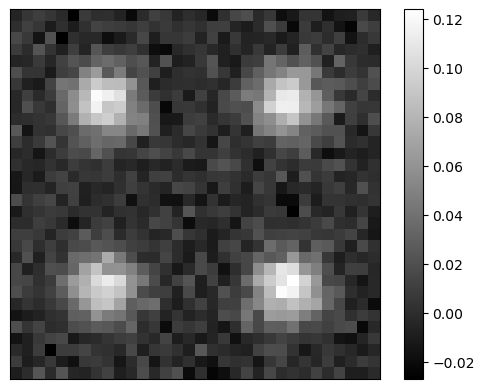

In [3]:
## Simulate Data
np.random.seed(1)

N = 2**10 # number of subjects in a group
labels = np.zeros((N*2,))
labels[N:] = 1

# 2 confounding effects between 2 groups
cf = np.zeros((N*2,))
cf[:N] = np.random.uniform(1,4,size=N)
cf[N:] = np.random.uniform(3,6,size=N)

# 2 major effects between 2 groups
mf = np.zeros((N*2,))
mf[:N] = np.random.uniform(1,4,size=N)
mf[N:] = np.random.uniform(3,6,size=N)

# simulate images
x = np.zeros((N*2,32,32,1))
y = np.zeros((N*2,))
y[N:] = 1
for i in range(N*2):
    x[i,:16,:16,0] = gkern(kernlen=16, nsig=5)*mf[i]
    x[i,16:,:16,0] = gkern(kernlen=16, nsig=5)*cf[i]
    x[i,:16,16:,0] = gkern(kernlen=16, nsig=5)*cf[i]
    x[i,16:,16:,0] = gkern(kernlen=16, nsig=5)*mf[i]
    x[i] = x[i] + np.random.normal(0,0.01,size=(32,32,1))

plt.imshow(x[1,:,:,0],cmap='gray')
plt.colorbar()
#plt.title("a synthetic training image");
plt.xticks(np.arange(0), ())
plt.yticks(np.arange(0), ())
plt.savefig('synthetic_sample.jpg', format='jpg', dpi=300)

# Training BR-Net

In [4]:

# Adversarial loss for squared correlation
def lossb_calc(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = torch.mean(x)
    my = torch.mean(y)
    xm, ym = x - mx, y - my
    r_num = torch.sum(torch.mul(xm, ym))
    r_den = torch.sqrt(torch.mul(torch.sum(torch.square(xm)), torch.sum(torch.square(ym)))) + 1e-5
    r = r_num / r_den

    r = torch.clamp(r, min=-1.0, max=1.0)
    return -torch.square(r)

# Adversarial loss for mse
def inv_mse(y_true, y_pred):
    mse_value = torch.sum(torch.square(y_true - y_pred))
    return -mse_value

lossp_calc = torch.nn.BCELoss()
#lossb_calc = torch.nn.MSELoss()

lossb_adverseral_calc = torch.nn.MSELoss()


In [5]:

class MyDataset(Dataset):
    def __init__(self, data, label, confounders):
        self.data = data
        self.label = label
        self.confounders = confounders
    def __getitem__(self, index):
        return self.data[index], self.label[index], self.confounders[index]
    def __len__(self):
        return len(self.label)

In [6]:
batch_size = 128
train_propotion = 0.8
i = int(N*2*train_propotion)

#convert data to float32
xx = x.astype(np.float32)
yy = y.astype(np.float32)
cfcf = cf.astype(np.float32)

train_x = xx[:i]
valid_x = xx[i:]

trainset = MyDataset(xx[:i],yy[:i], cfcf[:i])
valset = MyDataset(xx[i:],yy[i:], cfcf[i:])

train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, pin_memory=True,num_workers=1)
valid_loader = torch.utils.data.DataLoader(valset, batch_size, shuffle=False, pin_memory=True,num_workers=1)

In [7]:
class modelF1(nn.Module):
    """
    feature predictor
    """
    def __init__(self):
        super(modelF1, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(2, 4, kernel_size=3, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 8, kernel_size=3, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

    def forward(self, x):
        return self.conv(x)


class modelB1(nn.Module):
    """
    bias predictor
    """
    def __init__(self):
        super(modelB1, self).__init__()

        self.conv = nn.Sequential(
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1))

    def forward(self, x):
        return self.conv(x)

class modelP1(nn.Module):
    """
    predictor
    """
    def __init__(self):
        super(modelP1, self).__init__()

        self.conv = nn.Sequential(
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.conv(x)

In [8]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

device = torch.device("cuda" if train_on_gpu else "cpu")

CUDA is available. Training on GPU


In [9]:
modelF = modelF1()
modelP = modelP1()
modelB = modelB1()

modelF = torch.nn.DataParallel(modelF).to(device) # send tensor to device
modelP = torch.nn.DataParallel(modelP).to(device) # send tensor to device
modelB = torch.nn.DataParallel(modelB).to(device) # send tensor to device

In [10]:
opt = torch.optim.Adam(list(modelF.parameters())+ list(modelP.parameters())+list(modelB.parameters()), lr=0.0001)

In [11]:
epochs = 200

train_loss_list = []
valid_loss_list = []
train_lossb_list = []
valid_lossb_list = []


for epoch in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_lossb = 0.0
    valid_lossb = 0.0


    since = time.time()

    modelF.train()
    modelP.train()
    modelB.train()
    for x, y, b in train_loader: # b is bias
            #no control group as easier to train
            x = x.permute(0,3,1,2)
            y, b = torch.unsqueeze(y,1), torch.unsqueeze(b,1)
            x,y,b = x.to(device), y.to(device), b.to(device)
            F_pred = modelF(x)
            y_pred = modelP(F_pred)
            b_pred = modelB(F_pred)

            #no adversarial loss for the ctrl group
            lossp = lossp_calc(y_pred, y)
            lossb = lossb_calc(b_pred, b)
            lossb_adverseral = lossb_adverseral_calc(b_pred, b)

            train_loss += lossp.item()
            train_lossb += lossb.item()

            opt.zero_grad(True)
            # Step 1
            (lossp - lossb).backward(retain_graph=True, inputs = tuple(modelF.parameters())) #want to maximise lossb

            # Step 2
            (lossb_adverseral).backward(retain_graph=True, inputs = tuple(modelB.parameters())) # want to minimise lossb_adverseral (b is - corr^2 or mse) this is adverseral part

            # Step 3
            (lossp).backward(inputs= tuple(modelP.parameters()))

            opt.step()




    modelF.eval()
    modelP.eval()
    modelB.eval()
    with torch.no_grad(): #to increase the validation process uses less memory
        for x1, y1, b1 in valid_loader:
            x1 = x1.permute(0,3,1,2)
            y1, b1 = torch.unsqueeze(y1,1), torch.unsqueeze(b1,1)
            x1,y1,b1 = x1.to(device), y1.to(device), b1.to(device)

            F_pred = modelF(x1)
            y_pred = modelP(F_pred)
            b_pred = modelB(F_pred)

            lossp = lossp_calc(y_pred, y1)
            lossb = lossb_calc(b_pred, b1)

            valid_loss += lossp.item()
            valid_lossb += lossb.item()

            valid_loss += lossp.item()
            valid_lossb += lossb.item()

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    train_lossb /= len(train_loader)
    valid_lossb /= len(valid_loader) # hence this is the per batch loss


    train_loss_list += [train_loss]
    valid_loss_list += [valid_loss]
    train_lossb_list += [train_lossb]
    valid_lossb_list += [valid_lossb]


    if (epoch%100==0):
      #print time per epoch
      time_elapsed = time.time() - since
      print('Epoch {}/{}'.format(epoch+1, epochs),
            'Train loss: {:.4f}'.format(train_loss),
            'Valid loss: {:.4f}'.format(valid_loss),
            'Train lossb: {:.4f}'.format(train_lossb),
            'Valid lossb: {:.4f}'.format(valid_lossb),
            'Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Epoch 1/200 Train loss: 0.7184 Valid loss: 1.2271 Train lossb: -0.4972 Valid lossb: -0.1349 Time: 0m 1s
Epoch 101/200 Train loss: 0.6611 Valid loss: 1.9577 Train lossb: -0.0128 Valid lossb: -0.1087 Time: 0m 0s


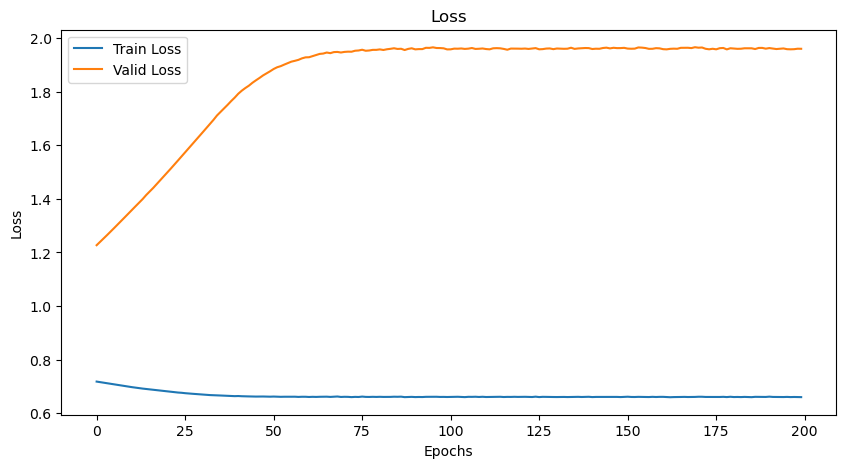

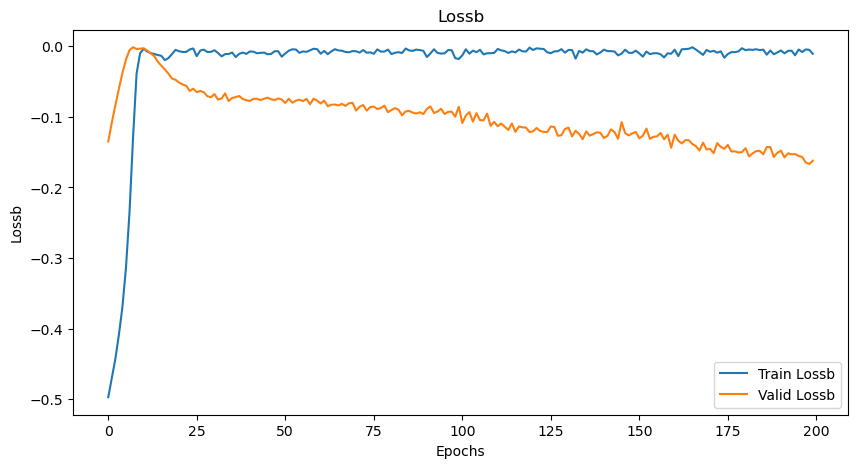

In [12]:
# Assuming you have the following variables defined:
# train_loss, valid_loss, train_lossb, valid_lossb

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_loss_list), label='Train Loss')
plt.plot(np.array(valid_loss_list), label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Plotting lossb
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_lossb_list), label='Train Lossb')
plt.plot(np.array(valid_lossb_list), label='Valid Lossb')
plt.xlabel('Epochs')
plt.ylabel('Lossb')
plt.title('Lossb')
plt.legend()
plt.show()


# Visualizing the Association between Features and Confounder

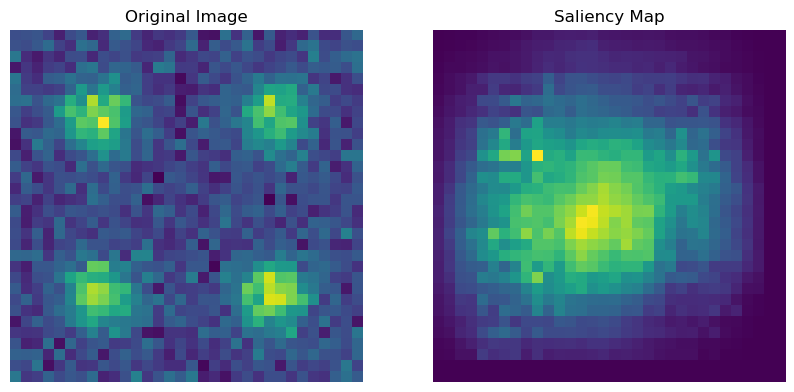

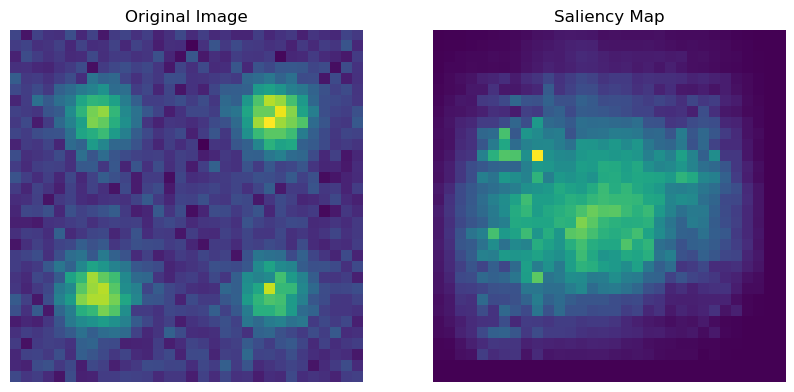

In [13]:
for x in [train_x, valid_x]:

  x = torch.tensor(x, dtype=torch.float32).to(device)
  x = x.permute(0,3,1,2)


  # Get the gradients of the output with respect to the input
  x.requires_grad_()

  modelF.eval()
  modelP.eval()
  output = modelP(modelF(x)).sum(dim=0)
  modelF.zero_grad()
  modelP.zero_grad()
  output.backward()

  # Compute the saliency map
  saliency_map = x.grad.abs().squeeze().mean(dim=0).cpu().numpy()

  # Normalize the saliency map
  saliency_map /= saliency_map.max()

  # Plot the original image and the saliency map
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(x[0,0,:,:].detach().cpu().numpy())
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(saliency_map)
  plt.title('Saliency Map')
  plt.axis('off')
  plt.show()

In [12]:
# dcorr loss
def dcor_loss_calc(X, Y):
    """ Compute the distance correlation function using PyTorch tensors"""
    #n = X.size(dim=1)

    # Compute distance matrices
    a = torch.cdist(X.unsqueeze(2), X.unsqueeze(2))
    b = torch.cdist(Y.unsqueeze(2), Y.unsqueeze(2))
    # assuming X, Y is a vector we unsqueeze



    # Compute double centered distance matrices
    A = a - a.mean(dim=1, keepdim=True) - a.mean(dim=2, keepdim=True) + a.mean(dim=(1,2), keepdim=True)
    B = b - b.mean(dim=1, keepdim=True) - b.mean(dim=2, keepdim=True) + b.mean(dim=(1,2), keepdim=True)

    # Compute distance covariance and variance
    dCovXY = (A * B).sum(dim=(1,2)) #/ (n**2)
    dVarX = (A**2).sum(dim=(1,2)) #/ (n**2)
    dVarY = (B**2).sum(dim=(1,2)) #/ (n**2)

    # Compute distance correlation
    dCorXY = dCovXY / (dVarX * dVarY).sqrt()

    return dCorXY.sum()

In [13]:
modelF_dcor = modelF1()
modelP_dcor = modelP1()

modelF_dcor = torch.nn.DataParallel(modelF_dcor).to(device) # send tensor to device
modelP_dcor = torch.nn.DataParallel(modelP_dcor).to(device) # send tensor to device

opt = torch.optim.Adam(list(modelF_dcor.parameters())+ list(modelP_dcor.parameters()), lr=0.0001)

In [15]:
lam = 1
epochs = 200


train_loss_dcor_list = []
valid_loss_dcor_list = []
train_lossb_dcor_list = []
valid_lossb_dcor_list = []

for epoch in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_lossb = 0.0
    valid_lossb = 0.0


    since = time.time()

    modelF_dcor.train()
    modelP_dcor.train()
    for x, y, b in train_loader: # b is bias
            #no control group as easier to train
            x,y,b = x.to(device), y.to(device), b.to(device)
            x = x.permute(0,3,1,2)
            y, b = torch.unsqueeze(y,1), torch.unsqueeze(b,1)
            F_pred = modelF_dcor(x)
            y_pred = modelP_dcor(F_pred)
            print(y_pred.min(), y_pred.max())
            print(y.min(), y.max())

            #no adversarial loss for the ctrl group
            lossp = lossp_calc(y_pred, y)
            lossb = dcor_loss_calc(F_pred, b)

            train_loss += lossp.item()
            train_lossb += lossb.item()

            opt.zero_grad(True)
            (lossp + lam*lossb).backward()
            opt.step()




    modelF_dcor.eval()
    modelP_dcor.eval()
    with torch.no_grad(): #to increase the validation process uses less memory
        for x1, y1, b1 in valid_loader:
            x1,y1,b1 = x1.to(device), y1.to(device), b1.to(device)
            x1 = x1.permute(0,3,1,2)
            y1, b1 = torch.unsqueeze(y1,1), torch.unsqueeze(b1,1)

            F_pred = modelF_dcor(x1)
            y_pred = modelP_dcor(F_pred)

            lossp = lossp_calc(y_pred, y1)
            lossb = dcor_loss_calc(F_pred, b1)

            valid_loss += lossp.item()
            valid_lossb += lossb.item()

            valid_loss += lossp.item()
            valid_lossb += lossb.item()

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    train_lossb /= len(train_loader)
    valid_lossb /= len(valid_loader) # hence this is the per batch loss


    train_loss_dcor_list += [train_loss]
    valid_loss_dcor_list += [valid_loss]
    train_lossb_dcor_list += [train_lossb]
    valid_lossb_dcor_list += [valid_lossb]


    if (epoch%100==0):
      #print time per epoch
      time_elapsed = time.time() - since
      print('Epoch {}/{}'.format(epoch+1, epochs),
            'Train loss: {:.4f}'.format(train_loss),
            'Valid loss: {:.4f}'.format(valid_loss),
            'Train lossb: {:.4f}'.format(train_lossb),
            'Valid lossb: {:.4f}'.format(valid_lossb),
            'Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:


# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_loss_dcor_list), label='Train Loss')
plt.plot(np.array(valid_loss_dcor_list), label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Plotting lossb
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_lossb_dcor_list), label='Train Lossb')
plt.plot(np.array(valid_lossb_dcor_list), label='Valid Lossb')
plt.xlabel('Epochs')
plt.ylabel('Lossb')
plt.title('Lossb')
plt.legend()
plt.show()


In [ ]:
for x in [train_x, valid_x]:

  x = torch.tensor(x, dtype=torch.float32).to(device)
  x = x.permute(0,3,1,2)


  # Get the gradients of the output with respect to the input
  x.requires_grad_()

  modelF_dcor.eval()
  modelP_dcor.eval()
  output = modelP_dcor(modelF_dcor(x)).sum(dim=0)
  modelF_dcor.zero_grad()
  modelP_dcor.zero_grad()
  output.backward()

  # Compute the saliency map
  saliency_map = x.grad.abs().squeeze().mean(dim=0).cpu().numpy()

  # Normalize the saliency map
  saliency_map /= saliency_map.max()

  # Plot the original image and the saliency map
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(x[0,0,:,:].detach().cpu().numpy())
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(saliency_map)
  plt.title('Saliency Map')
  plt.axis('off')
  plt.show()